In [11]:
from PIL import Image
import numpy as np



from setup_imports import root_dir
from sam2.sam2_image_predictor import SAM2ImagePredictor

from semantic_sam2.build_semantic_sam2 import build_semantic_sam2

In [12]:
# Build semantic SAM2

sam2_checkpoint = "../checkpoints/sam2.1_hiera_base_plus.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_b+.yaml"

model = build_semantic_sam2(
    config_file="configs/sam2.1/sam2.1_hiera_b+.yaml",  # Use base config
    ckpt_path=sam2_checkpoint,
    device="cuda",
    hydra_overrides_extra=[
        "++model._target_=semantic_sam2.semantic_sam2_components.SAM2Semantic",
        "++model.num_classes=9",
    ],
    use_load_checkpoint_staged_safe=True
)

# Create predictor
predictor = SAM2ImagePredictor(model)

# Set image
image = Image.open(root_dir / 'notebooks/images/truck.jpg')
image = np.array(image.convert("RGB"))
predictor.set_image(image)

input_point=None
input_label=None
# input_point = np.array([[500, 375]])
# input_label = np.array([1])

# Predict with prompts - now outputs 9 masks (one per class)
masks, iou_predictions, low_res_masks = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=False,  # Set to True to get all class masks
)

# masks shape: [9, H, W] - one mask per class

print(f"Returned masks shape: {masks.shape}")

import matplotlib.pyplot as plt

# assume masks.shape = (9, 1200, 1800)

fig, axes = plt.subplots(3, 3, figsize=(12, 12))  # 3x3 grid
axes = axes.flatten()

for i in range(9):
    axes[i].imshow(masks[i], cmap="gray")
    axes[i].set_title(f"Mask {i}")
    axes[i].axis("off")

plt.tight_layout()
plt.show()

InstantiationException: Error in call to target 'sam2.modeling.sam.transformer.RoPEAttention':
AcceleratorError('CUDA error: out of memory\nCUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.\nFor debugging consider passing CUDA_LAUNCH_BLOCKING=1\nCompile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.\n')
full_key: model.memory_attention.layer.self_attention

### Load trained model

Returned masks shape: (9, 1024, 1024)


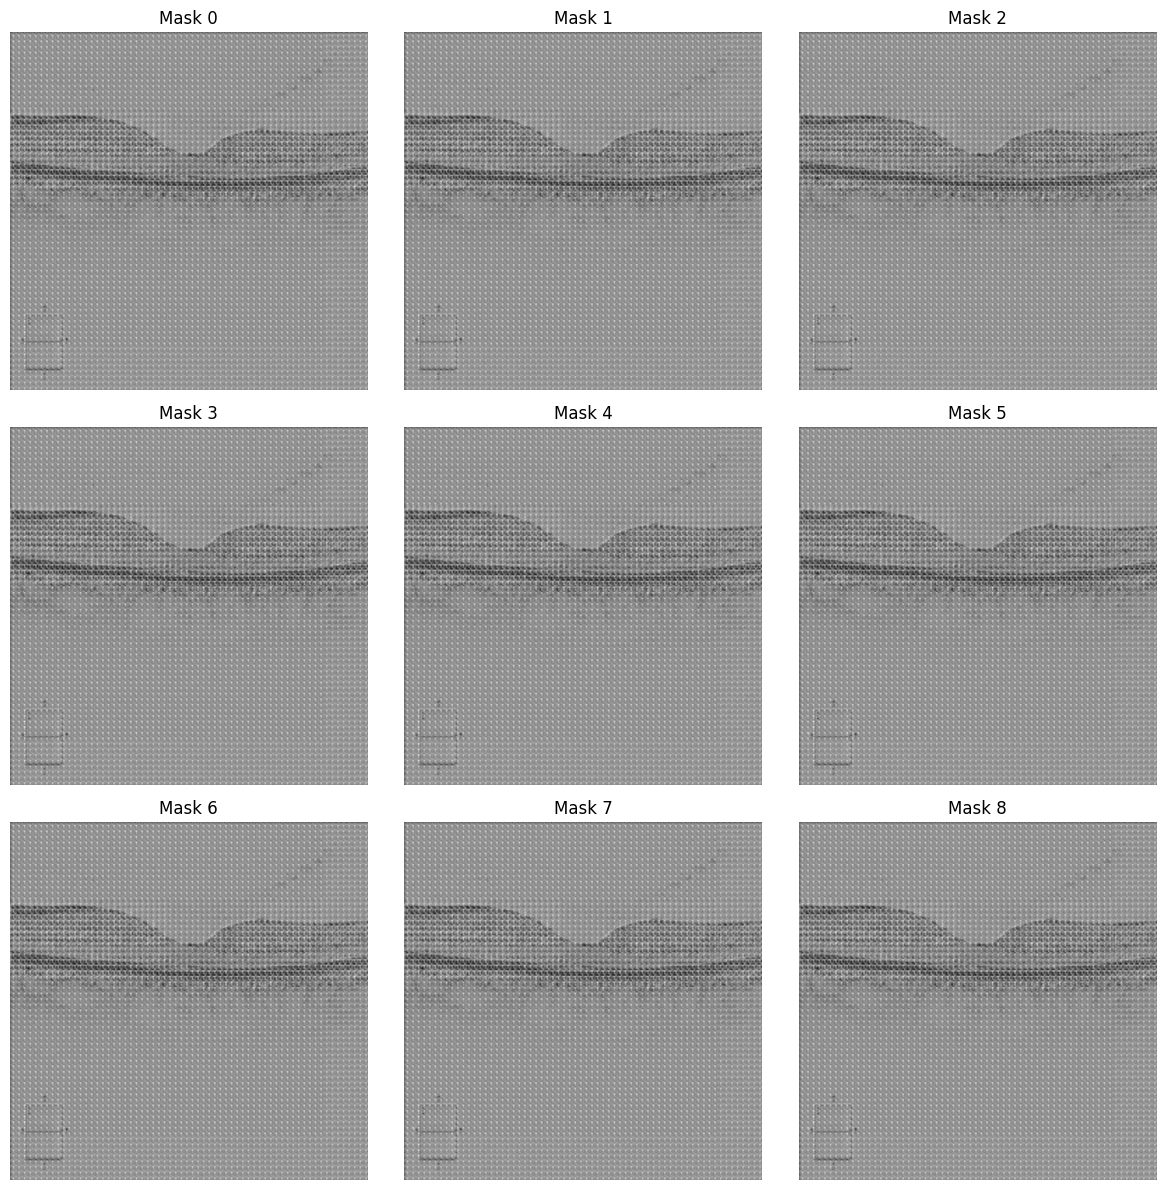

In [ ]:
# Build semantic SAM2

# sam2_checkpoint = "../checkpoints/sam2.1_hiera_base_plus.pt"
sam2_checkpoint = root_dir/"semantic_sam2_runs/best.pt"
model_cfg = root_dir/"configs/sam2.1/sam2.1_hiera_b+.yaml"

model = build_semantic_sam2(
    config_file="configs/sam2.1/sam2.1_hiera_b+.yaml",  # Use base config
    ckpt_path=str(sam2_checkpoint),
    device="cuda",
    hydra_overrides_extra=[
        "++model._target_=semantic_sam2.semantic_sam2_components.SAM2Semantic",
        "++model.num_classes=9",
    ],
    use_load_checkpoint_staged_safe=True
)

# Create predictor
predictor = SAM2ImagePredictor(model)

# Set image
# image = Image.open(root_dir / 'notebooks/images/truck.jpg')
image = Image.open("D:/GitHub/segment_anything_private/processed_data/Healthy/val/img_stretched/NORMAL129.png")
image = np.array(image.convert("RGB"))
predictor.set_image(image)

input_point=None
input_label=None
# input_point = np.array([[500, 375]])
# input_label = np.array([1])

# Predict with prompts - now outputs 9 masks (one per class)
masks, iou_predictions, low_res_masks = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=False,  # Set to True to get all class masks
    return_logits=True
)

print(f"Returned masks shape: {masks.shape}")

import matplotlib.pyplot as plt

# assume masks.shape = (9, 1200, 1800)
argmax_mask = np.argmax(masks, axis=0)  # shape: (H, W)


fig, axes = plt.subplots(3, 3, figsize=(12, 12))  # 3x3 grid
axes = axes.flatten()

for i in range(9):
    axes[i].imshow(masks[i], cmap="gray")
    axes[i].set_title(f"Mask {i}")
    axes[i].axis("off")

plt.tight_layout()
plt.show()

In [1]:
from setup_imports import root_dir
from torch.utils.data import DataLoader, Dataset
from pathlib import Path
from typing import Dict, Optional
from PIL import Image
import torch
import random
import torchvision.transforms.functional as TF
import numpy as np

from semantic_sam2.build_semantic_sam2 import build_semantic_sam2

IMAGE_EXTENSIONS = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"}

IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD = (0.229, 0.224, 0.225)


class PairedImageMaskDataset(Dataset):
    """Dataset that pairs images and masks located in separate directories."""

    def __init__(
        self,
        image_dir: Path,
        mask_dir: Path,
        image_size: int,
        num_classes: Optional[int] = None,
        ignore_index: Optional[int] = None,
        augment: bool = False,
    ) -> None:
        self.image_dir = Path(image_dir)
        self.mask_dir = Path(mask_dir)
        if not self.image_dir.exists():
            raise FileNotFoundError(f"Image directory not found: {self.image_dir}")
        if not self.mask_dir.exists():
            raise FileNotFoundError(f"Mask directory not found: {self.mask_dir}")

        mask_lookup = {}
        mask_candidates = [
            p
            for p in self.mask_dir.rglob("*")
            if p.is_file() and p.suffix.lower() in IMAGE_EXTENSIONS
        ]
        if not mask_candidates:
            raise ValueError(f"No mask files found under {self.mask_dir}")
        for mask_path in mask_candidates:
            stem = mask_path.stem
            if stem in mask_lookup:
                print(
                    "Duplicate mask stem '%s' found; keeping first instance.", stem
                )
                continue
            mask_lookup[stem] = mask_path

        image_candidates = [
            p
            for p in self.image_dir.rglob("*")
            if p.is_file() and p.suffix.lower() in IMAGE_EXTENSIONS
        ]
        if not image_candidates:
            raise ValueError(f"No image files found under {self.image_dir}")

        self.pairs = []
        for image_path in sorted(image_candidates):
            mask_path = mask_lookup.get(image_path.stem)
            if mask_path is None:
                print(
                    "Skipping '%s' because no matching mask was found.", image_path.name
                )
                continue
            self.pairs.append((image_path, mask_path))

        if not self.pairs:
            raise ValueError(
                "No image/mask pairs found. Ensure filenames match between directories."
            )

        self.image_size = image_size
        self.num_classes = num_classes
        self.ignore_index = ignore_index
        self.augment = augment
        resampling = getattr(Image, 'Resampling', None)
        if resampling is not None:
            self._image_resample = resampling.BILINEAR
            self._mask_resample = resampling.NEAREST
        else:
            self._image_resample = Image.BILINEAR
            self._mask_resample = Image.NEAREST

    def __len__(self) -> int:
        return len(self.pairs)

    def __getitem__(self, index: int) -> Dict[str, torch.Tensor]:
        image_path, mask_path = self.pairs[index]
        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path)

        if self.augment:
            if random.random() < 0.5:
                image = TF.hflip(image)
                mask = TF.hflip(mask)
            if random.random() < 0.5:
                image = TF.vflip(image)
                mask = TF.vflip(mask)

        mask = mask.resize((self.image_size, self.image_size), resample=self._mask_resample)
        mask_array = np.array(mask, dtype=np.int64)
        if mask_array.ndim == 3:
            mask_array = mask_array[..., 0]

        mask_tensor = torch.tensor(mask_array, dtype=torch.long)
        if self.num_classes is not None:
            invalid = mask_tensor >= self.num_classes
            if invalid.any():
                if self.ignore_index is not None:
                    mask_tensor[invalid] = self.ignore_index
                else:
                    mask_tensor[invalid] = self.num_classes - 1
        if self.ignore_index is not None:
            negative = mask_tensor < 0
            if negative.any():
                mask_tensor[negative] = self.ignore_index

        image = image.resize((self.image_size, self.image_size), resample=self._image_resample)
        image_tensor = TF.to_tensor(image)
        image_tensor = TF.normalize(image_tensor, IMAGENET_MEAN, IMAGENET_STD)

        return {
            "image": image_tensor,
            "mask": mask_tensor,
            "image_path": str(image_path),
            "mask_path": str(mask_path),
        }
    


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pin_memory = device.type == "cuda"

hydra_overrides = [
    "++model._target_=semantic_sam2.semantic_sam2_components.SAM2Semantic",
    f"++model.num_classes={9}",
    "++model.num_maskmem=0",
    "++model.use_mask_input_as_output_without_sam=false",
]

sam2_checkpoint = root_dir/"semantic_sam2_runs/best.pt"
# sam2_checkpoint =root_dir/"checkpoints/sam2.1_hiera_base_plus.pt"

model = build_semantic_sam2(
    config_file="configs/sam2.1/sam2.1_hiera_b+.yaml",
    ckpt_path=str(sam2_checkpoint),
    device=str(device),
    mode="eval",
    hydra_overrides_extra=hydra_overrides,
    apply_postprocessing=False,
    use_load_checkpoint_staged_safe=True,
)

model.num_maskmem = 0
model.use_mask_input_as_output_without_sam = False


val_dataset = PairedImageMaskDataset(
    image_dir=Path(r"D:\GitHub\segment_anything_private\processed_data\Healthy\val\img_stretched"),
    mask_dir=Path(r"D:\GitHub\segment_anything_private\processed_data\Healthy\val\mask_stretched"),
    image_size=model.image_size,
    num_classes=9,
    ignore_index=-1,
    augment=False,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=0,
    pin_memory=pin_memory,
    drop_last=False,
)




val_iter = iter(val_loader)
batch = next(val_iter)

images = batch["image"].to(device, non_blocking=True)


backbone_out = model.forward_image(images)
_, vision_feats, _, feat_sizes = model._prepare_backbone_features(backbone_out)
batch_size = images.size(0)
if len(vision_feats) > 1:
    high_res_features = [
        feat.permute(1, 2, 0).reshape(batch_size, feat.size(2), *size)
        for feat, size in zip(vision_feats[:-1], feat_sizes[:-1])
    ]
else:
    high_res_features = None
fused_features = vision_feats[-1].permute(1, 2, 0).reshape(
    batch_size, vision_feats[-1].size(2), *feat_sizes[-1]
)
sam_outputs = model._forward_sam_heads(
    backbone_features=fused_features,
    point_inputs=None,
    mask_inputs=None,
    high_res_features=high_res_features,
    multimask_output=False,
)
_, high_res_multimasks, _, _, _, _, _ = sam_outputs

Returned masks shape: (9, 1024, 1024)


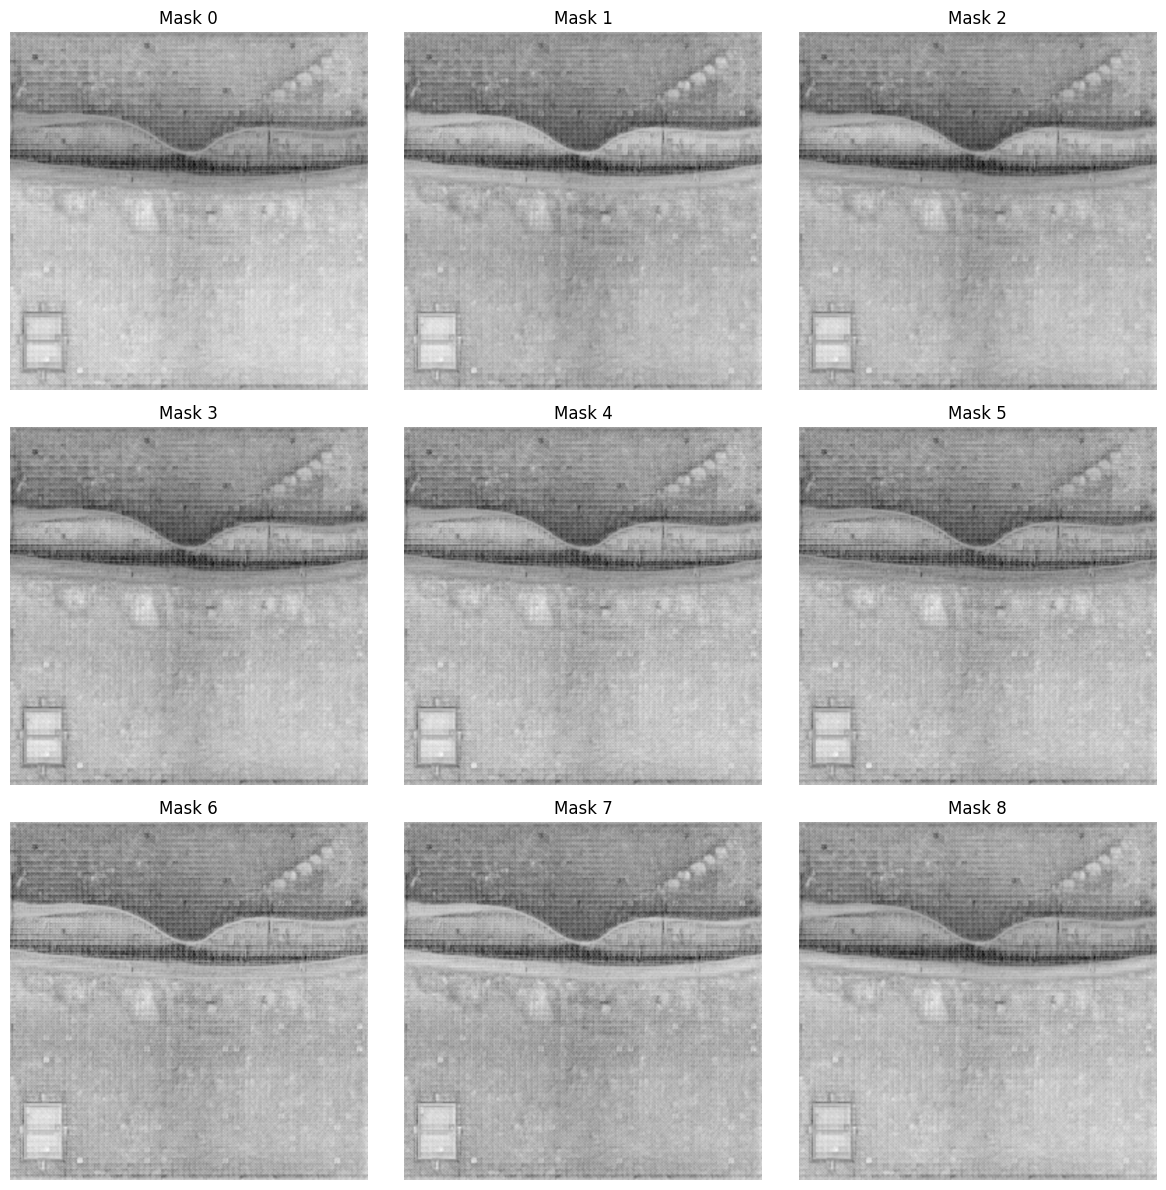

In [2]:
masks = high_res_multimasks.squeeze(0).detach().cpu().numpy()
print(f"Returned masks shape: {masks.shape}")

import matplotlib.pyplot as plt

# assume masks.shape = (9, 1200, 1800)
argmax_mask = np.argmax(masks, axis=0)  # shape: (H, W)


fig, axes = plt.subplots(3, 3, figsize=(12, 12))  # 3x3 grid
axes = axes.flatten()

for i in range(9):
    axes[i].imshow(masks[i], cmap="gray")
    axes[i].set_title(f"Mask {i}")
    axes[i].axis("off")

plt.tight_layout()
plt.show()

In [3]:
torch.unique(high_res_multimasks)


tensor([-124.6355, -124.3295, -124.2252,  ...,   65.8415,   66.2511,
          66.4274], device='cuda:0', grad_fn=<Unique2Backward0>)

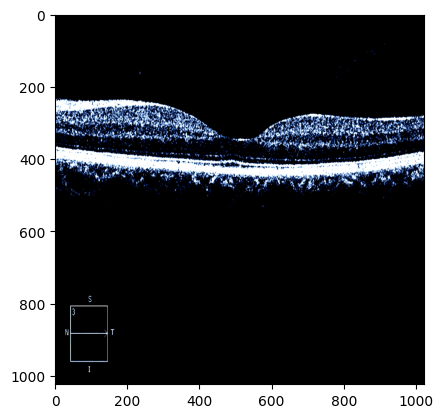

In [4]:
plt.imshow(images.squeeze(0).permute(1,2,0).cpu())

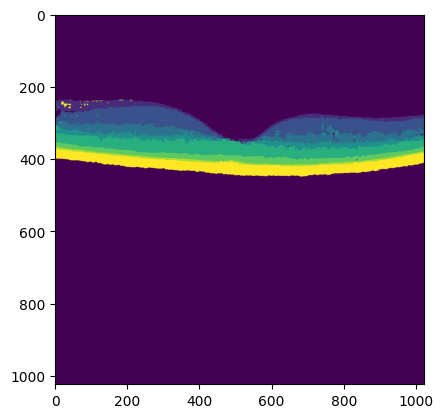

In [5]:
plt.imshow(argmax_mask)